# Import Library

In [ ]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

In [25]:
import pandas as pd
import numpy as np
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import cv2
import matplotlib.pyplot as plt
import wandb
from wandb.keras import WandbMetricsLogger
%matplotlib inline

wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

# Dataset Loader and Preparation

In [26]:
# Import image 

def load_img_train_dataset():
    
    annotations = pd.read_csv('annotations.csv') # <= Set Your Annotation Path Here!!!

    X_train=[]
    y_train=[]
    for i in range(len(annotations)):
        
        filename = annotations.iloc[i]['id'] # get filename from annotations
        label = annotations.iloc[i]['class'] # get class from annotations

        img = cv2.imread('freq_img_gray_bgsup/train/'+ filename +'.jpg') # import image <= Set Your Image Path Here!!!
        
        img = cv2.resize(img, (256, 256)) ## Configure Your Image Size Here!!!
        
        X_train.append(img)
        y_train.append(label)

    return X_train, y_train

In [3]:
X_train, y_train = load_img_train_dataset()

# Change to List to Array
X_train = np.array(X_train)
y_train = np.array(y_train)

# Train Val Split 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=58)

print('Before SMOTE')
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print()

# smote
from imblearn.over_sampling import SMOTE

train_size = X_train.shape[0]
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train.reshape(train_size,-1),y_train)

train_size = X_train.shape[0]
X_train = X_train.reshape(train_size, 256, 256, 3)

# print('After SMOTE')
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

Before SMOTE
(516, 256, 256, 3)
(516,)
(130, 256, 256, 3)
(130,)

(658, 256, 256, 3)
(658,)
(130, 256, 256, 3)
(130,)


In [4]:
# One Hot Encoder
encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train.reshape(-1,1)).toarray()
y_val = encoder.fit_transform(y_val.reshape(-1,1)).toarray()

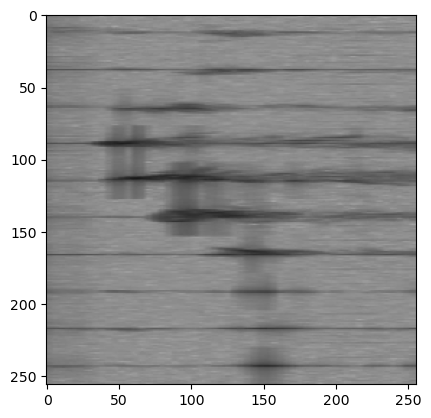

In [5]:
plt.imshow(X_train[0])

# Model Setting
- https://keras.io/api/applications/ (Base Model with Pretrained)

In [27]:
# Model
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, GlobalMaxPooling2D, Dropout

# Base Model (Can configure)
from tensorflow.keras.applications import EfficientNetV2S

# Optimizers (Can configure)
from tensorflow.keras.optimizers import Adam

# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [28]:
# Base model can be configured, also the input shape  
basemodel = EfficientNetV2S(weights="imagenet", include_top=False, input_shape=(256, 256, 3)) # setting input shape
for layer in basemodel.layers:
    if 'block6' in layer.name:
        layer.trainable = True
    elif 'block5' in layer.name:
        layer.trainable = True
    elif 'top' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

model = Sequential()
model.add(basemodel)
model.add(GlobalMaxPooling2D(name="gap")) # can configure
# model.add(Flatten(name="flatten"))  # can configure <= มีหรือไม่มีก็ได้ เพราะ globalmaxpool ทำให้แล้ว
model.add(Dense(128, activation='relu', name="fc1")) # can configure
model.add(Dropout(0.4, name="dropout_out"))
model.add(Dense(7, activation="softmax", name="fc_out"))

# Display Model Architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 8, 8, 1280)       20331360  
 l)                                                              
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 fc1 (Dense)                 (None, 128)               163968    
                                                                 
 dropout_out (Dropout)       (None, 128)               0         
                                                                 
 fc_out (Dense)              (None, 7)                 903       
                                                                 
Total params: 20,496,231
Trainable params: 18,520,783
Non-trainable params: 1,975,448
__________________________________

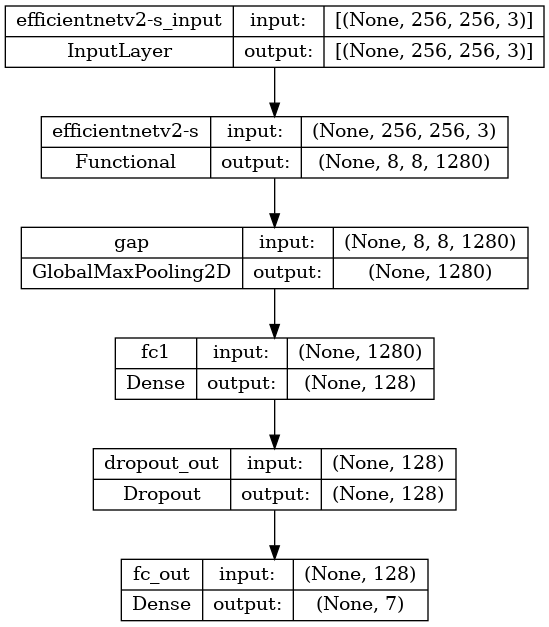

wandb: Waiting for W&B process to finish... (success).


In [29]:
import tensorflow as tf
tf.keras.utils.plot_model(
    model,
    to_file="freq_graph.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

In [8]:
# Freezeing base model

basemodel.trainable = True

In [9]:
# Training Parameters Setting
run_name = f'EfficientNetV2S-freq-bgsup-gray'
result_path = f'img-results/{run_name}'
if not os.path.exists(result_path):
    os.mkdir(result_path)

config = {
    'architecture': 'EfficientNetV2S',
    'lr': 1e-3,
    'early_stop_patience' : 15,
    'epochs': 200,
    'batch_size': 16,
    'best_model_path': f'img-results/{run_name}/best_model.h5'
}

In [10]:
# Setting Optimizer, Loss , and Metric

model.compile(optimizer=Adam(learning_rate= config['lr']),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
# Setting Callbacks

checkpoint = ModelCheckpoint(config['best_model_path'],
                             verbose=1,
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min')

earlyStopping = EarlyStopping(monitor='val_loss',
                              patience=config['early_stop_patience'],
                              verbose=0,
                              mode='min')

# Train

In [12]:
# Wandb
wandb.init(project = f"{run_name}", config=config)

# Train
history = model.fit(X_train,
                    y_train,
                    batch_size = config['batch_size'],
                    epochs = config['epochs'],
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlyStopping, WandbMetricsLogger()])

Epoch 1/200


2023-03-10 03:41:03.339313: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetv2-s/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-03-10 03:41:08.507322: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-10 03:41:09.049460: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-10 03:41:09.975582: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7faac0012ec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-10 03:41:09.975615: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-03-10 03:41:09.980388: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash repr

42/42 [==============================] - ETA: 0s - loss: 2.1412 - accuracy: 0.3556
Epoch 1: val_loss improved from inf to 1.68357, saving model to img-results/EfficientNetV2S-freq-bgsup-gray/best_model.h5
42/42 [==============================] - 85s 432ms/step - loss: 2.1412 - accuracy: 0.3556 - val_loss: 1.6836 - val_accuracy: 0.3308
Epoch 2/200
42/42 [==============================] - ETA: 0s - loss: 1.3301 - accuracy: 0.4772
Epoch 2: val_loss improved from 1.68357 to 0.95462, saving model to img-results/EfficientNetV2S-freq-bgsup-gray/best_model.h5
42/42 [==============================] - 15s 353ms/step - loss: 1.3301 - accuracy: 0.4772 - val_loss: 0.9546 - val_accuracy: 0.6615
Epoch 3/200
42/42 [==============================] - ETA: 0s - loss: 1.0187 - accuracy: 0.5988
Epoch 3: val_loss did not improve from 0.95462
42/42 [==============================] - 13s 313ms/step - loss: 1.0187 - accuracy: 0.5988 - val_loss: 1.7297 - val_accuracy: 0.5231
Epoch 4/200
42/42 [=================

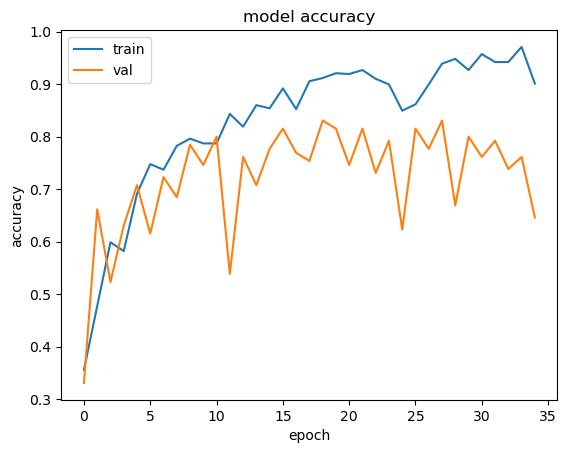

In [13]:
# Visualize Training Graph
# Accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

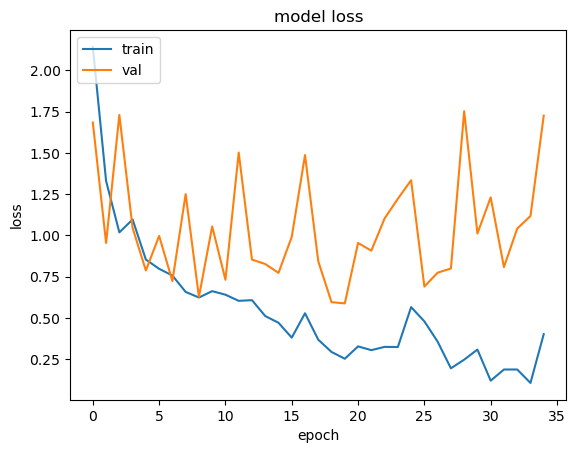

In [14]:
# Loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Eval

In [15]:
from keras.models import load_model # For loading Model

5/5 [==============================] - 4s 109ms/step
              precision    recall  f1-score   support

           0       0.62      0.56      0.59         9
           1       0.81      0.85      0.83        20
           2       0.82      0.75      0.78        12
           3       0.60      0.88      0.71        17
           4       0.92      0.88      0.90        26
           5       1.00      0.95      0.97        19
           6       0.86      0.70      0.78        27

    accuracy                           0.82       130
   macro avg       0.81      0.80      0.79       130
weighted avg       0.83      0.82      0.82       130

[[ 5  1  2  1  0  0  0]
 [ 0 17  0  3  0  0  0]
 [ 3  0  9  0  0  0  0]
 [ 0  2  0 15  0  0  0]
 [ 0  0  0  0 23  0  3]
 [ 0  0  0  0  1 18  0]
 [ 0  1  0  6  1  0 19]]


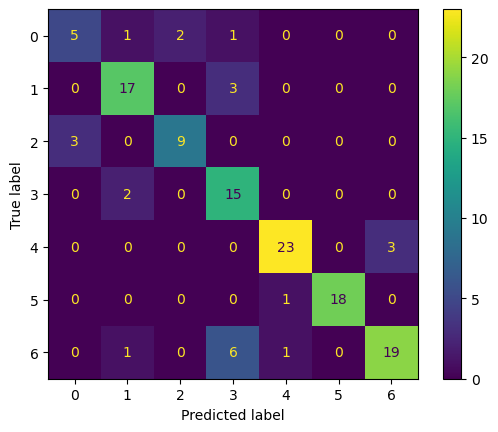

In [16]:
# Load Best weight into Model
best_weight_path = 'img-results/EfficientNetV2S-freq-bgsup-gray/best_model.h5' # <= Set Your Best Weight Path Here!!!
model = load_model(best_weight_path)

val_pred = model.predict(np.array(X_val))

val_pred = np.argmax(val_pred, axis = 1)

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_true=np.argmax(y_val, axis = 1), y_pred=val_pred))

cm = confusion_matrix(y_true=np.argmax(y_val, axis = 1), y_pred=val_pred)
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Test

In [17]:
# Load Sample Submission File 

df = pd.read_csv('sample_submission.csv')
df.head()

,id,class
0,30de3513-93ff-42d8-ad5f-4c93f4a4444c,6.0
1,84e55af1-ae63-4b06-b650-1136d38b691e,4.0
2,2471a7eb-af35-4ae7-870e-6650de9f0c2f,2.0
3,d00e8bdc-79af-4e55-b25a-96ea589b6420,NaN
4,ad9f77bc-5ab6-477d-b760-2f3fc65c14d3,NaN


In [19]:
test = []
for i in range(len(df)):
    filename = 'freq_img_gray_bgsup/test/'+df.iloc[i]['id']+'.jpg' # <= Set Your Image Path Here!!!
    img = cv2.imread(filename) # import image 
    img = cv2.resize(img, (256,256))# <= Set Your Image Size Here!!!
    test.append(img)

In [20]:
test = np.array(test) # Convert to array

# Load Best weight into Model
# best_weight_path = 'img-results/EfficientNetV2S-freq-gray/best_model.h5' # <= Set Your Best Weight Path Here!!!
# model = load_model(best_weight_path)

# Prediction
pred = model.predict(test)

# Get Prediction result
result = np.argmax(pred, axis=1)

6/6 [==============================] - 1s 244ms/step


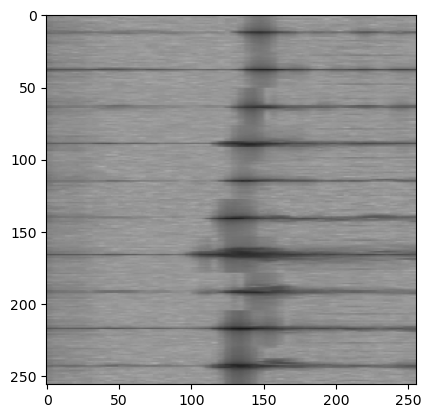

In [21]:
plt.imshow((test[4]))

In [22]:
# Check Your Result
df['class'] = result
df.head()

,id,class
0,30de3513-93ff-42d8-ad5f-4c93f4a4444c,3
1,84e55af1-ae63-4b06-b650-1136d38b691e,5
2,2471a7eb-af35-4ae7-870e-6650de9f0c2f,2
3,d00e8bdc-79af-4e55-b25a-96ea589b6420,4
4,ad9f77bc-5ab6-477d-b760-2f3fc65c14d3,0


In [23]:
df

,id,class
0,30de3513-93ff-42d8-ad5f-4c93f4a4444c,3
1,84e55af1-ae63-4b06-b650-1136d38b691e,5
2,2471a7eb-af35-4ae7-870e-6650de9f0c2f,2
3,d00e8bdc-79af-4e55-b25a-96ea589b6420,4
4,ad9f77bc-5ab6-477d-b760-2f3fc65c14d3,0
...,...,...
159,5fce955d-1068-40b3-afc3-111f8c22c9f9,3
160,f3a000be-07c9-44ad-8ff0-b89a9a1070dd,4
161,84d3963b-cfed-450c-88ab-ca853273d15c,1
162,7b36184c-5541-44d9-9200-8057bd3cf4ef,6


In [24]:
# Save Your Result

path_to_save = f'img-results/{run_name}/{run_name}_submission.csv' # <= Set Your Save Path Here!!!
df.to_csv(path_to_save,index=False)

print("= Good Luck ="*20)

= Good Luck == Good Luck == Good Luck == Good Luck == Good Luck == Good Luck == Good Luck == Good Luck == Good Luck == Good Luck == Good Luck == Good Luck == Good Luck == Good Luck == Good Luck == Good Luck == Good Luck == Good Luck == Good Luck == Good Luck =
